In [14]:
import re
import nltk
import tensorflow
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from gensim.corpora import Dictionary
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
df = pd.read_csv("reviews.csv")   # adjust path if needed

# Step 3: Create the 'labels' column
df['labels'] = df['sentiment'].apply(lambda x: 1 if x.lower() == 'positive' else 0)

In [5]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags
"]+", flags=re.UNICODE)

def preprocessing_text_fast(text):
    # Lowercase once
    text = text.lower()
    # Remove numbers and punctuation
    text = re.sub(r'[^a-z\s]', ' ', text)
    # Remove emojis
    text = emoji_pattern.sub(r'', text)
    # Lemmatize and remove stopwords
    tokens = [lemmatizer.lemmatize(w) for w in text.split() if w not in stop_words]
    return ' '.join(tokens)

# ✅ Apply with progress bar
tqdm.pandas()
df['proc_review'] = df['review'].progress_apply(preprocessing_text_fast)

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:44<00:00, 1114.72it/s]


In [6]:
df.head()

,review,sentiment,labels,proc_review
0,One of the other reviewers has mentioned that ...,positive,1,one reviewer mentioned watching oz episode hoo...
1,A wonderful little production. <br /><br />The...,positive,1,wonderful little production br br filming tech...
2,I thought this was a wonderful way to spend ti...,positive,1,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,0,basically family little boy jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,petter mattei love time money visually stunnin...


In [7]:
# Tokenize reviews
sentences = [text.split() for text in df['proc_review']]

# Build dictionary
dictionary = Dictionary(sentences)

# Convert to sequences (+1 so 0 is reserved for padding)
sequences = [[idx + 1 for idx in dictionary.doc2idx(sentence)] for sentence in sentences]

# Determine suitable max length (90th percentile)
lengths = [len(seq) for seq in sequences]
max_len = int(np.percentile(lengths, 90))

# Pad sequences
X = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post', value=0)

df['padded_sequence'] = X.tolist()

print(f"Max length used: {max_len}")
print(f"Padded shape: {X.shape}")
print("Example padded sequence:", X[0][:20])
print(df.head())

Max length used: 242
Padded shape: (50000, 242)
Example padded sequence: [ 83  97  75 131  86  32  58  98  34  53  11  11  41 120 116  86  12 126
 102 129]
                                              review sentiment  labels  \
0  One of the other reviewers has mentioned that ...  positive       1   
1  A wonderful little production. <br /><br />The...  positive       1   
2  I thought this was a wonderful way to spend ti...  positive       1   
3  Basically there's a family where a little boy ...  negative       0   
4  Petter Mattei's "Love in the Time of Money" is...  positive       1   

                                         proc_review  \
0  one reviewer mentioned watching oz episode hoo...   
1  wonderful little production br br filming tech...   
2  thought wonderful way spend time hot summer we...   
3  basically family little boy jake think zombie ...   
4  petter mattei love time money visually stunnin...   

                                     padded_sequence  
0  [83,

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['padded_sequence'], df['labels'], test_size=0.2,shuffle=True,random_state=15)
# Convert to numpy arrays
X_train = np.array(X_train.tolist())
X_test = np.array(X_test.tolist())
y_train = np.array(y_train)
y_test = np.array(y_test)

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [9]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, num_layers=1, dropout=0.5, output_dim=1):
        super(SentimentLSTM, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, hidden_dim, num_layers=num_layers,
            batch_first=True, dropout=dropout if num_layers > 1 else 0
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)                     # [batch, seq_len, embedding_dim]
        lstm_out, (h_n, c_n) = self.lstm(embedded)       # lstm_out: [batch, seq_len, hidden_dim]
        out = self.dropout(h_n[-1])                      # take final hidden layer
        out = self.fc(out)
        out = self.sigmoid(out)
        return out.squeeze()                             # [batch]


In [10]:
from torch.utils.data import TensorDataset, DataLoader

# Create TensorDataset
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)


In [12]:
vocab_size = len(dictionary) + 1  # +1 for padding index 0
embedding_dim = 128
hidden_dim = 128
num_layers = 1
output_dim = 1

model = SentimentLSTM(vocab_size=vocab_size, dropout=0.5).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
num_epochs = 5
train_losses, train_accs, test_accs = [], [], []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    all_preds, all_labels = [], []

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for inputs, labels in loop:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # accumulate loss
        epoch_loss += loss.item()

        # predictions for metrics
        preds = (outputs > 0.5).float()
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())

    # Compute training metrics
    train_loss = epoch_loss / len(train_loader)
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='micro')

    train_losses.append(train_loss)
    train_accs.append(acc)

    print(f"\n[Epoch {epoch+1}]")
    print(f"Train Loss: {train_loss:.4f} | Accuracy: {acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")




Epoch 1/5: 100%|█████████████████████████████████████████████████████████████████████| 625/625 [04:07<00:00,  2.53it/s]



[Epoch 1]
Train Loss: 0.6863 | Accuracy: 0.5216 | Precision: 0.5216 | Recall: 0.5216 | F1: 0.5216


Epoch 2/5: 100%|█████████████████████████████████████████████████████████████████████| 625/625 [04:10<00:00,  2.50it/s]



[Epoch 2]
Train Loss: 0.6619 | Accuracy: 0.5633 | Precision: 0.5633 | Recall: 0.5633 | F1: 0.5633


Epoch 3/5: 100%|█████████████████████████████████████████████████████████████████████| 625/625 [03:30<00:00,  2.96it/s]



[Epoch 3]
Train Loss: 0.6061 | Accuracy: 0.6826 | Precision: 0.6826 | Recall: 0.6826 | F1: 0.6826


Epoch 4/5: 100%|█████████████████████████████████████████████████████████████████████| 625/625 [03:34<00:00,  2.92it/s]



[Epoch 4]
Train Loss: 0.4730 | Accuracy: 0.8022 | Precision: 0.8022 | Recall: 0.8022 | F1: 0.8022


Epoch 5/5: 100%|█████████████████████████████████████████████████████████████████████| 625/625 [03:16<00:00,  3.18it/s]


[Epoch 5]
Train Loss: 0.3651 | Accuracy: 0.8604 | Precision: 0.8604 | Recall: 0.8604 | F1: 0.8604


In [16]:
    # --------------------------
    # Evaluation on Test Set
    # --------------------------
    model.eval()
    test_preds, test_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            preds = (outputs > 0.5).float()
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    test_acc = accuracy_score(test_labels, test_preds)
    test_accs.append(test_acc)
    



✅ Final Test Results:
Accuracy : 0.8362
Precision: 0.8362
Recall   : 0.8362
F1 Score : 0.8362


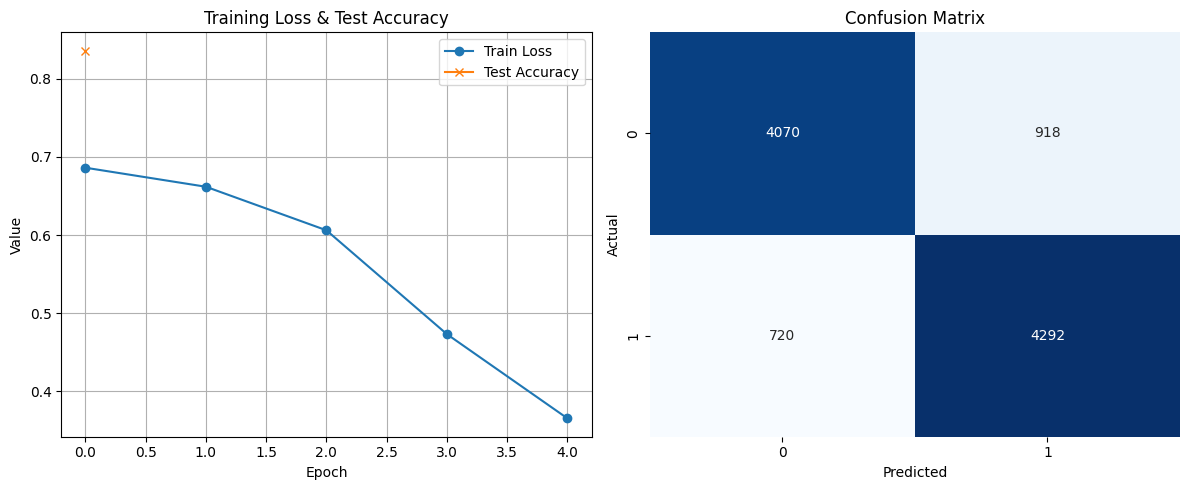

In [17]:
# ------------------------------
# 5️⃣ Final Evaluation on Test Set
# ------------------------------
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='micro')
cm = confusion_matrix(test_labels, test_preds)

print("\n✅ Final Test Results:")
print(f"Accuracy : {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

# ------------------------------
# 6️⃣ Visualization (Loss Curve + Confusion Matrix)
# ------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# (a) Loss curve
axes[0].plot(train_losses, marker='o', label='Train Loss')
axes[0].plot(test_accs, marker='x', label='Test Accuracy')
axes[0].set_title("Training Loss & Test Accuracy")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Value")
axes[0].legend()
axes[0].grid(True)

# (b) Confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[1])
axes[1].set_title("Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()